In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy import stats
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates


class Stock():
    def __init__(self, data):
        self.data = data
        self.date = data.index
        self.prices = data['Close']
        self.models = None
        self.func = self.geometric_brownian_motion
    
    def close(self):
        self.prices = self.data['Close']
        return self
    def open(self):
        self.prices = self.data['Open']
        return self
    def high(self):
        self.prices = self.data['High']
        return self
    def low(self):
        self.prices = self.data['Low']
        return self
    
    def log(self):
        return  self.prices.apply(np.log)
    def diff(self):
        return self.prices.apply(np.diff)
    def log_diff(self):
        return self.prices.apply(np.log).apply(np.diff)
    def print_prices(self):
        return self.prices

            
    def average(self):
        return float(self.prices.mean())
    def standard_deviation(self):
        return float(self.prices.std())
    def drift(self):
        return float(self.diff().dropna().mean())
    def volatility(self):
        return float(self.diff().dropna().std())
    
    def average_log(self):
        return float(self.log().mean())
    def standard_deviation_log(self):
        return float(self.log().std())
    def drift_log(self):
        return float(self.log_diff().mean())
    def volatility_log(self):
        return float(self.log_diff().std())
    
    def plot(self):
        plt.figure(figsize=(12, 6))
        for model in self.models:
            plt.plot(self.date, model)
        plt.ylabel('price ($)')
        plt.grid(True)
        plt.show
        return self.line
    
    def simulation(self, n):
        models = []
        for i in range(n):
            S = self.func()
            models.append(S)
        self.models = models
        return self.models
    
    def geometric_brownian_motion(self):
        t = np.arange(len(self.date))
        W = np.random.standard_normal(len(self.date))
        W = np.cumsum(W)
        X = (self.drift_log() - 0.5 * self.volatility_log()**2) * t + self.volatility_log() * W
        S = float(self.prices.iloc[0]) * np.exp(X)
        self.func = self.geometric_brownian_motion
        return S
    
    def candlestick(self, day=200, moving_average=[5, 10, 20 ,50, 75, 100]):
        # prepare data
        candlestick_data = self.data.copy()
        candlestick_data = candlestick_data.reset_index()
        candlestick_data['Date'] = candlestick_data['Date'].map(mdates.date2num)
        candlestick_data = candlestick_data[-day:]

        fig, ax = plt.subplots(figsize=(12, 6))
        # illustrate a candlestick
        candlestick_ohlc(ax, candlestick_data[['Date', 'Open', 'High', 'Low', 'Close']].values, 
                        width=1, colorup='g', colordown='r')
        # add a moving average
        for ma in moving_average:
            candlestick_data[f'MA{ma}'] = candlestick_data['Close'].rolling(ma).mean()
            ax.plot(candlestick_data['Date'], candlestick_data[f'MA{ma}'], label=f'{ma} day moving average')

        ax.xaxis_date()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.title(f'candlestick')
        plt.xlabel('Date')
        plt.ylabel('price (USD)')
        plt.legend()
        plt.grid(True)
        plt.show()


class Option():
    def __init__(self, stock: Stock, strike_price: float, maturity: float, open_time=0):
        self.stock = stock
        self.K = strike_price
        self.T = maturity
        self.t = open_time

class Call(Option):
    def __init__(self, stock: Stock, strike_price: float, maturity: float, open_time: float=0):
        super().__init__(stock, strike_price, maturity, open_time=0)

    def European(self):
        return European(self)
    
class Put(Option):
    def __init__(self, stock: Stock, strike_price: float, maturity: float, open_time: float=0):
        super().__init__(stock, strike_price, maturity, open_time=0)

    def European(self):
        return European(self)


    
class European(Call):
    def __init__(self, option):
        self.option = option
        self.stock = option.stock
        self.K = option.K
        self.T = option.T
        self.t = option.t
        self.r = option.r
        self.mu = option.stock.drift()
        self.sigma = option.stock.volatility()
        self.S0 = option.stock.prices.iloc[self.t]
        self.type = option.type

    def __call__(self):
        return self.closed_form()

    def closed_form(self):
        d1 = (np.log(self.S0) - np.log(self.K) + (self.mu + 0.5 * self.sigma**2) * (self.T - self.t)) / (self.sigma * np.sqrt(self.T - self.t))
        d2 = d1 - self.sigma * np.sqrt(self.T - self.t)
        call_price = self.S0 * stats.norm.cdf(d1) - self.K * np.exp(-self.r * (self.T - self.t)) * stats.norm.cdf(d2)
        return call_price

        

[*********************100%***********************]  1 of 1 completed


Ticker              TM
Date                  
2020-03-02  132.710007
2020-03-03  130.949997
2020-03-04  131.850006
2020-03-05  129.199997
2020-03-06  127.110001
...                ...
2025-03-26  189.279999
2025-03-27  183.979996
2025-03-28  179.070007
2025-03-31  176.529999
2025-04-01  174.990005

[1279 rows x 1 columns]


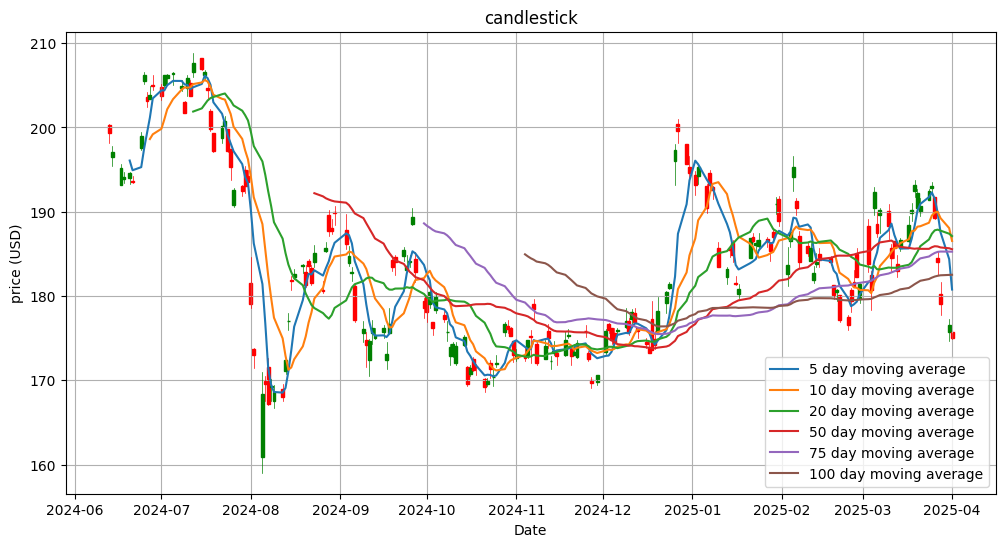

log Ticker            TM
Date                
2020-03-02  4.888166
2020-03-03  4.874816
2020-03-04  4.881665
2020-03-05  4.861362
2020-03-06  4.845053
...              ...
2025-03-26  5.243227
2025-03-27  5.214827
2025-03-28  5.187777
2025-03-31  5.173491
2025-04-01  5.164729

[1279 rows x 1 columns]
diff Ticker        TM
0      -1.760010
1       0.900009
2      -2.650009
3      -2.089996
4      -4.320000
...          ...
1273   -3.729996
1274   -5.300003
1275   -4.909988
1276   -2.540009
1277   -1.539993

[1278 rows x 1 columns]
log diff Ticker        TM
0      -0.013351
1       0.006849
2      -0.020303
3      -0.016309
4      -0.034577
...          ...
1273   -0.019515
1274   -0.028400
1275   -0.027050
1276   -0.014286
1277   -0.008762

[1278 rows x 1 columns]
CE <__main__.Call object at 0x7f6dda1a15e0>


/tmp/ipykernel_2444/159491971.py:56: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(self.log_diff().mean())
/tmp/ipykernel_2444/159491971.py:58: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(self.log_diff().std())
/tmp/ipykernel_2444/159491971.py:82: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S = float(self.prices.iloc[0]) * np.exp(X)


In [39]:
import yfinance as yf
if __name__ == "__main__":
    # # サンプルデータ（AAPL株価）の取得
    stock_data = yf.download('TM', start='2020-03-01') #, end='2023-12-31')
    
    # yfinance_stockクラスのインスタンス
    stock = Stock(stock_data)
    stock.close()
    print(stock.print_prices())
    stock.candlestick()
    print('log', stock.log())
    print('diff', stock.diff())
    print('log diff', stock.log_diff())
    stock.close().geometric_brownian_motion()
    stock.simulation(20)
    # stock.plot()
    print('CE', Call(stock, 100, 1))